In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Load the data
master = pd.read_csv('master1.csv')

# Filter relevant crime types
relevant_crime_types = ['HOMICIDE', 'BATTERY', 'ASSAULT', 'ROBBERY', 'CRIMINAL SEXUAL ASSAULT']
master = master[master['Primary Type'].isin(relevant_crime_types)]

# Drop irrelevant columns
columns_to_drop = ['Case Number', 'Time', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic','Beat','District','Ward','Community Area','FBI Code','X Coordinate',
                'Y Coordinate','Updated On','Latitude','Longitude','Location', 'Holiday Day of Week','precipprob','snowdepth','preciptype', 'windgust','winddir',
                'solarenergy','sunrise', 'sunset','moonphase', 'description', 'icon','stations']
data = master.drop(columns=columns_to_drop)

# Replace NaN values with 0 indicating no holiday and severe risk
data['Holiday'] = data['Holiday'].fillna(0)
data['severerisk'] = data['severerisk'].fillna(0)

# Replace non-NaN values with 1 indicating a holiday
data['Holiday'] = data['Holiday'].apply(lambda x: 1 if x != 0 else 0)

# Filter data for years after 2010
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y')
data = data[data['Date'].dt.year >= 2010]

# Group by date and get crime counts
daily_counts = data.groupby('Date').size().reset_index(name='Crime_Count')

# Merge daily counts with the original DataFrame
merged_data = pd.merge(data, daily_counts, on='Date')

# Drop duplicate rows to keep only one entry per day
final_data = merged_data.drop_duplicates(subset='Date')

# Split conditions column and create dummy variables
final_data['conditions'] = final_data['conditions'].str.split(',')
final_data = final_data.join(final_data['conditions'].str.join('|').str.get_dummies())

# Drop unnecessary columns
final_data.drop(columns=['conditions'], inplace=True)

final_data['Crime_Count'] = np.sqrt(final_data['Crime_Count'])

# Save final data to a CSV file

# Split the data into features (X) and target variable (y)
X = final_data.drop(columns=['Crime_Count', 'ID', 'Date'])
y = final_data['Crime_Count']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# Train OLS model
X_with_intercept = sm.add_constant(X_train)  # Add intercept term
sm_model = sm.OLS(y_train, X_with_intercept).fit()

# Access p-values
p_values = sm_model.pvalues
print("P-values:")
print(p_values)

# Print variable names and p-values without scientific notation
for variable, p_value in zip(X.columns, p_values):
    print(f"{variable}: {p_value:.10f}")

C:\Users\Matt\AppData\Local\Temp\ipykernel_6196\2820750549.py:10: DtypeWarning: Columns (23,24,36,49,50,52,53,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  master = pd.read_csv('master1.csv')


Mean Squared Error: 0.34229462905098207
R^2 Score: 0.2599319160873944
P-values:
const                              2.738954e-03
FullMoon                           4.608383e-02
Holiday                            3.492140e-01
tempmax                            6.324106e-01
tempmin                            7.198880e-01
temp                               5.968790e-01
feelslikemax                       7.385189e-01
feelslikemin                       3.452091e-01
feelslike                          5.493939e-02
dew                                9.418282e-01
humidity                           6.900599e-01
precip                             1.154273e-02
precipcover                        3.291627e-01
snow                               6.247355e-02
windspeed                          2.944299e-01
sealevelpressure                   1.729470e-01
cloudcover                         5.453243e-02
visibility                         8.142012e-01
solarradiation                     3.166489e-13
uvindex 

C:\Users\Matt\AppData\Local\Temp\ipykernel_6196\2820750549.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['conditions'] = final_data['conditions'].str.split(',')


In [7]:
from scipy.stats import shapiro

# Calculate residuals
residuals = y_test - y_pred

# Perform Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = shapiro(residuals)
print("Shapiro-Wilk Test:")
print("Statistic:", shapiro_statistic)
print("p-value:", shapiro_p_value)

# Interpret the results
alpha = 0.05
if shapiro_p_value > alpha:
    print("Residuals are normally distributed (fail to reject H0)")
else:
    print("Residuals are not normally distributed (reject H0)")


Shapiro-Wilk Test:
Statistic: 0.99903804063797
p-value: 0.8777165412902832
Residuals are normally distributed (fail to reject H0)


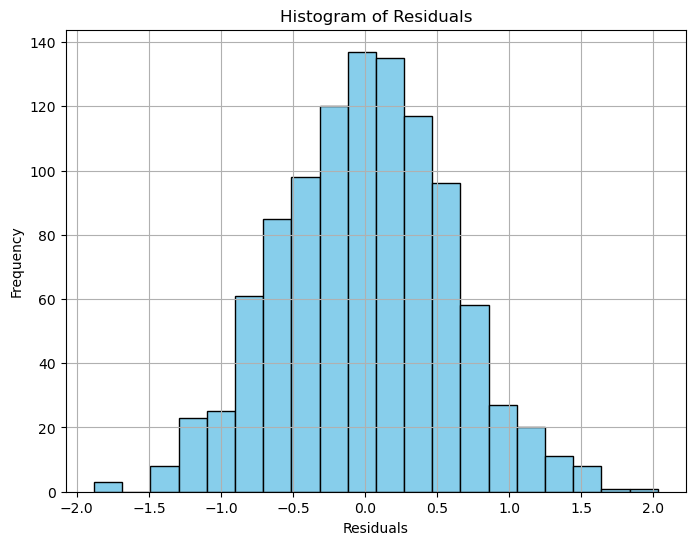

In [8]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred

# Plot histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [9]:
# Print variable names and p-values less than 0.05
print("Variables with p-values < 0.05:")
for variable, p_value in zip(X.columns, p_values):
    if p_value < 0.05:
        print(f"{variable}: {p_value:.10f}")

Variables with p-values < 0.05:
FullMoon: 0.0027389536
Holiday: 0.0460838299
precipcover: 0.0115427343
uvindex: 0.0000000000
severerisk: 0.0352673802
 Freezing Drizzle/Freezing Rain: 0.0000000000
Overcast: 0.0023914140
Partially cloudy: 0.0075545118
Rain: 0.0041296931
Snow: 0.0053355972
